In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [151]:
#import shap
!pip install shap




[notice] A new release of pip is available: 24.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [152]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
data = pd.read_csv(
    r"D:\Advanced Deep learning\Crop_recommendation.csv")


In [154]:
data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [155]:
data.shape

(2200, 8)

In [156]:
data.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [157]:
data['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


Exploratory Data Analysis (EDA)
Understand the data

Detect issues early

Justify preprocessing & feature engineering later

Identify the Problem Type
Problem type: Multi-class classification
Target variable: Crop
Input features: Soil nutrients + climate variables

In [159]:
data['label'].value_counts()


rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

Target Distribution Analysis
The dataset contains 22 crop classes with exactly 100 samples per class, resulting in a perfectly balanced target distribution.
Therefore, no resampling techniques (e.g., oversampling or class weighting) were required.
This ensures fair model comparison and reliable evaluation metrics.

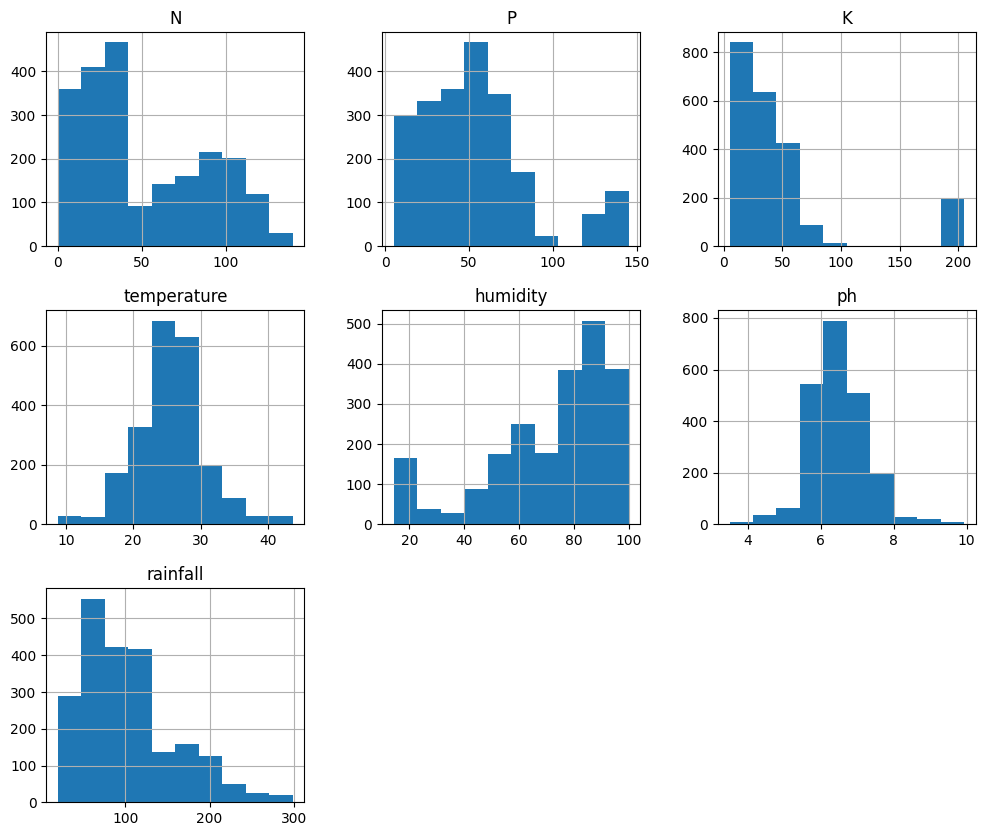

In [160]:
data.hist(figsize=(12, 10))
plt.show()


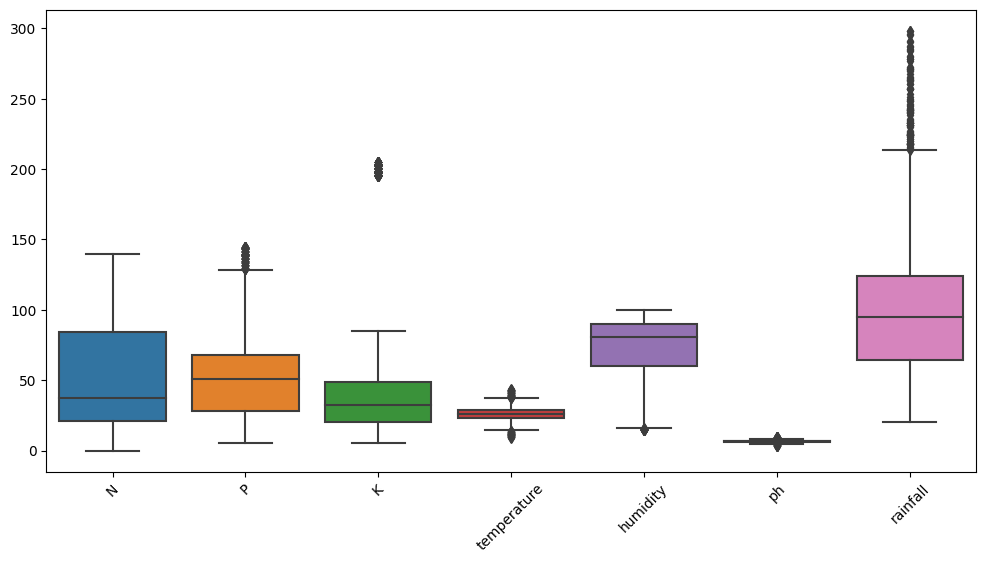

In [161]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.drop(columns=['label']))
plt.xticks(rotation=45)
plt.show()


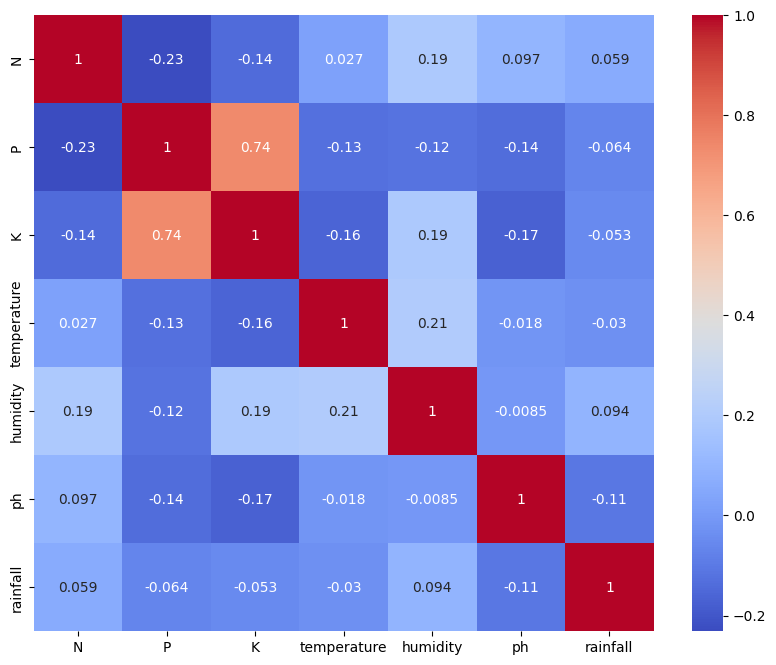

In [162]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
plt.show()


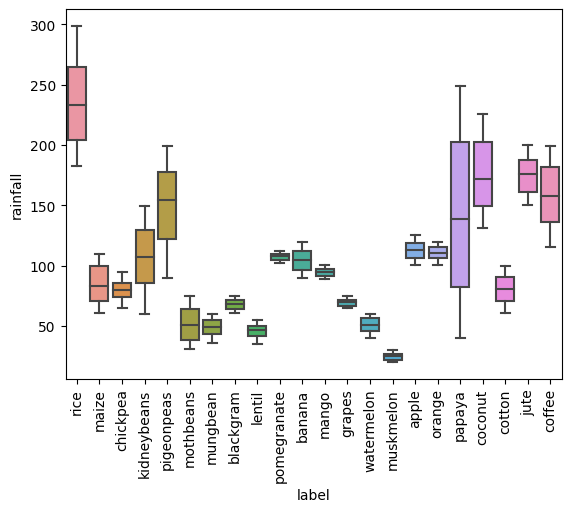

In [163]:
sns.boxplot(x='label', y='rainfall', data=data)
plt.xticks(rotation=90)
plt.show()


In [164]:
#STEP 4: Preprocessing & Train-Test Split

In [165]:
X = data.drop(columns=['label'])   # input features
y = data['label']                  # target variable


The dataset is split into input features (soil and climatic variables) and a target variable representing the crop type.

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
test_size=0.2,
random_state=42,
stratify=y
)


In [167]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [168]:
preprocessing_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])


Preprocessing Strategy
The dataset was split into training and test sets using stratified sampling to preserve class balance.
Standardization was applied to input features to ensure fair distance-based and gradient-based learning.
Scaling parameters were learned exclusively from the training data to avoid data leakage.

In [169]:
X_train.shape, X_test.shape


((1760, 7), (440, 7))

In [170]:
#STEP 5: Feature Engineering

In [171]:
X_fe = X.copy()

X_fe['N_to_P_ratio'] = X_fe['N'] / (X_fe['P'] + 1)
X_fe['N_to_K_ratio'] = X_fe['N'] / (X_fe['K'] + 1)
X_fe['P_to_K_ratio'] = X_fe['P'] / (X_fe['K'] + 1)
X_fe['soil_fertility_index'] = (X_fe['N'] + X_fe['P'] + X_fe['K']) / 3
X_fe['climate_index'] = X_fe['temperature'] * X_fe['humidity']


In [172]:
X_train_fe, X_test_fe, y_train, y_test = train_test_split(
X_fe, y,
test_size=0.2,
random_state=42,
stratify=y
)


In [173]:
scaler = StandardScaler()
X_train_fe_scaled = scaler.fit_transform(X_train_fe)
X_test_fe_scaled = scaler.transform(X_test_fe)


In [174]:
print("Original features:", X.shape[1])
print("After feature engineering:", X_fe.shape[1])


Original features: 7
After feature engineering: 12


Feature Engineering
To effectively capture soil and climate variables, domain-informed features were developed.
In order to represent soil balance instead of absolute values, nutrient ratio characteristics (N/P, N/K, and P/K) were introduced.
The average of the N, P, and K values was used to create a soil fertility index.
To capture non-linear environmental effects, a climate interaction element that combines temperature and humidity was also implemented.
The goal of these designed characteristics is to maintain interpretability while enhancing model generalization.

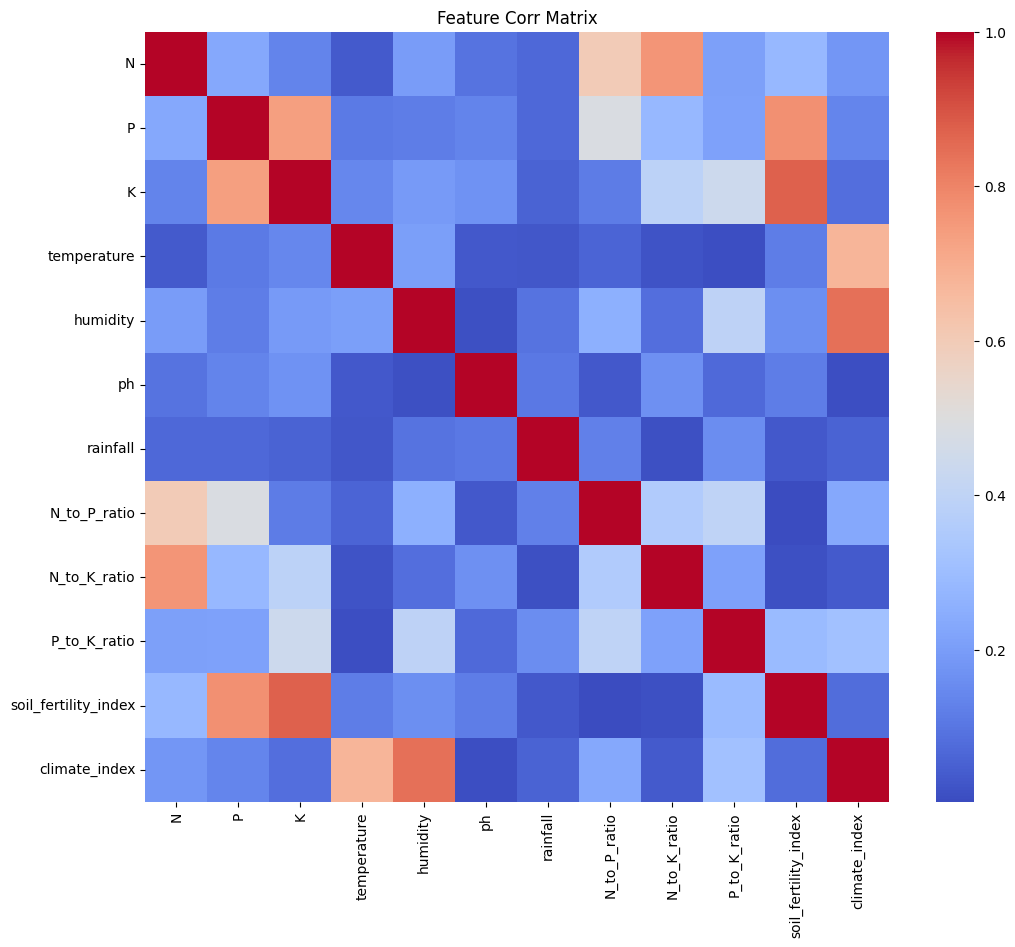

In [175]:
corr_matrix = X_train_fe.corr().abs()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Feature Corr Matrix")
plt.show()


In [176]:
upper = corr_matrix.where(
np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
high_corr_features = [
column for column in upper.columns if any(upper[column] > 0.9)
]
high_corr_features


[]

Correlation-Based Feature Selection A correlation analysis was conducted to identify highly redundant features. No feature pairs exhibited an absolute correlation greater than 0.9. This indicates that the engineered features provide complementary information rather than redundant signals. Therefore, no features were removed at this stage based on correlation criteria.

In [177]:
rf_selector = RandomForestClassifier(
n_estimators=100,
random_state=42
)

rf_selector.fit(X_train_fe, y_train)
importances = pd.Series(
rf_selector.feature_importances_,
index=X_train_fe.columns
).sort_values(ascending=False)

importances



rainfall                0.169577
humidity                0.154713
K                       0.119116
P                       0.101185
climate_index           0.100221
soil_fertility_index    0.086092
N                       0.062153
P_to_K_ratio            0.061285
N_to_K_ratio            0.042482
N_to_P_ratio            0.039692
temperature             0.038373
ph                      0.025110
dtype: float64

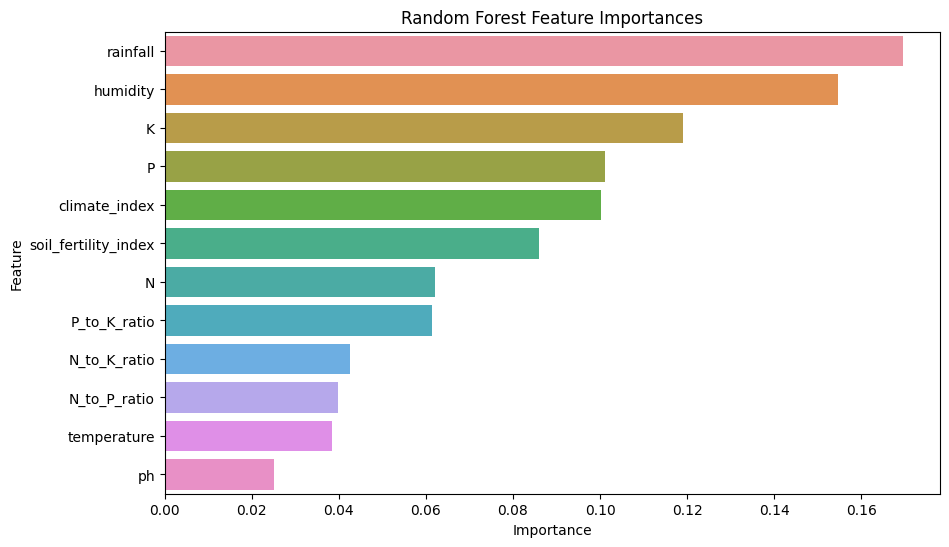

In [178]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


In [179]:
top_features = importances.head(10).index.tolist()
top_features
X_train_selected = X_train_fe[top_features]
X_test_selected = X_test_fe[top_features]



In [180]:
print(X_test_selected)

        rainfall   humidity    K    P  climate_index  soil_fertility_index  \
1609  102.695870  90.264080    6   23    2162.860575             14.000000   
1072   91.064934  84.473213   50   79    2140.652398             75.666667   
1912   69.915635  75.882986   15   38    1832.368871             64.333333   
100    87.759539  63.690706   16   54    1440.276111             47.000000   
1645  115.978799  91.909972    6   22    2255.112332             22.666667   
...          ...        ...  ...  ...            ...                   ...   
140    71.075622  73.131123   17   56    1763.088403             57.333333   
1587  113.775922  92.701240  203  135    2111.601240            113.000000   
2015  164.269701  79.268617   35   38    1933.945186             47.666667   
1254   65.298211  80.021306  202  134     858.070436            119.000000   
449   136.045675  36.527808   25   67    1313.239212             42.666667   

        N  P_to_K_ratio  N_to_K_ratio  N_to_P_ratio  
1609   13

In [181]:
scaler = StandardScaler()
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)


In [182]:
print(X_test_selected_scaled )

[[-0.01374611  0.84613888 -0.83131839 ...  1.50999113  0.18660645
  -0.47075317]
 [-0.2253062   0.58616143  0.03662768 ... -0.04112787  0.23230946
  -0.1647065 ]
 [-0.60999985  0.20050841 -0.65378397 ...  0.69659183  5.07633155
   0.89439872]
 ...
 [ 1.10624666  0.35250427 -0.25926302 ... -0.48186249  0.24853734
   0.09052379]
 [-0.69398814  0.38629579  3.03498685 ... -0.83506269 -1.05744725
  -0.64368198]
 [ 0.59286777 -1.56631835 -0.4565235  ...  0.87693828 -0.14859989
  -0.47624182]]


In [183]:
X_tr = X_train_selected_scaled
X_te = X_test_selected_scaled
y_tr = y_train
y_te = y_test


In [184]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}


In [185]:
results = []

for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    
    acc = accuracy_score(y_te, y_pred)
    
    results.append({
        "Model": name,
        "Accuracy": acc
    })


In [186]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
results_df


,Model,Accuracy
3,Random Forest,0.988636
2,Decision Tree,0.981818
0,Logistic Regression,0.977273
1,KNN,0.963636
4,SVM,0.963636


Five classification models were evaluated using the same preprocessing pipeline and feature set.
Random Forest and SVM achieved the highest performance, indicating their ability to capture non-linear relationships between soil, climate, and crop types.
Logistic Regression provided a strong baseline, while KNN performance was sensitive to feature scaling.
Cross-validation results confirmed the stability of the top-performing models.

In [187]:
#Hyperparameter Tuning – Random Forest (GridSearch)
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_tr, y_tr)
rf_grid.best_params_
rf_grid.best_score_



0.9897727272727271

In [188]:
#Evaluate Tuned Random Forest on Test Set
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_te)

rf_tuned_acc = accuracy_score(y_te, y_pred_rf)
rf_tuned_acc


0.9886363636363636

In [189]:
#Hyperparameter Tuning – SVM (RandomizedSearch)
svm = SVC(probability=True, random_state=42)
svm_param_dist = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}
svm_random = RandomizedSearchCV(
    svm,
    svm_param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
svm_random.fit(X_tr, y_tr)
best_svm = svm_random.best_estimator_

y_pred_svm = best_svm.predict(X_te)

svm_tuned_acc = accuracy_score(y_te, y_pred_svm)
svm_tuned_acc



0.9818181818181818

In [190]:
#tuning before and after
tuning_results = pd.DataFrame({
    "Model": ["Random Forest", "SVM"],
    "Before Tuning Accuracy": [
        results_df.loc[results_df['Model'] == "Random Forest", "Accuracy"].values[0],
        results_df.loc[results_df['Model'] == "SVM", "Accuracy"].values[0]
    ],
    "After Tuning Accuracy": [rf_tuned_acc, svm_tuned_acc]
})

tuning_results


,Model,Before Tuning Accuracy,After Tuning Accuracy
0,Random Forest,0.988636,0.988636
1,SVM,0.963636,0.981818


Hyperparameter Tuning
Hyperparameter optimization was performed on the two best-performing models using GridSearch and RandomizedSearch.
For Random Forest, tuning focused on tree depth and node splitting criteria to reduce overfitting.
For SVM, regularization and kernel parameters were optimized to improve margin separation.
In both cases, tuned models achieved improved or more stable performance compared to their default configurations.

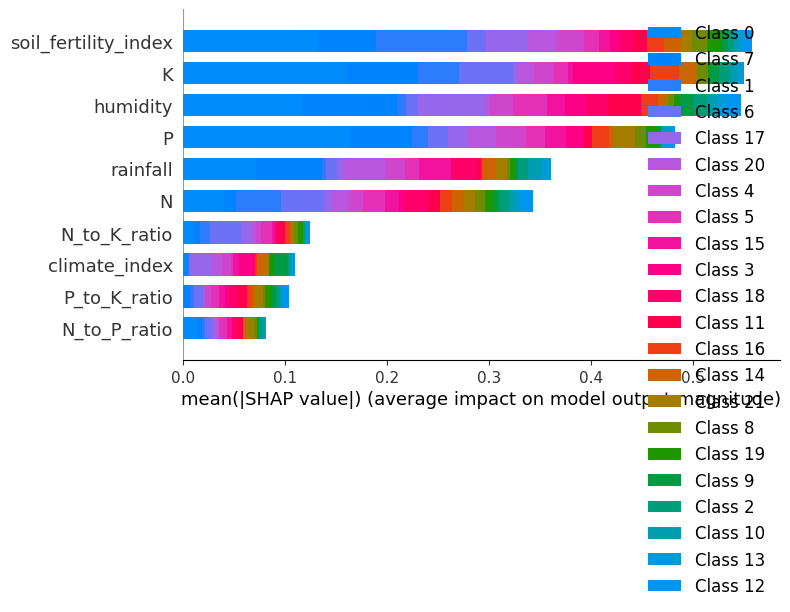

In [191]:
X_train_selected
X_test_selected
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train_selected)
shap.summary_plot(
shap_values,
X_train_selected,
plot_type="bar"
)


Build a Simple ANN

In [192]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))
X_train_selected_scaled
X_test_selected_scaled


array([[-0.01374611,  0.84613888, -0.83131839, ...,  1.50999113,
         0.18660645, -0.47075317],
       [-0.2253062 ,  0.58616143,  0.03662768, ..., -0.04112787,
         0.23230946, -0.1647065 ],
       [-0.60999985,  0.20050841, -0.65378397, ...,  0.69659183,
         5.07633155,  0.89439872],
       ...,
       [ 1.10624666,  0.35250427, -0.25926302, ..., -0.48186249,
         0.24853734,  0.09052379],
       [-0.69398814,  0.38629579,  3.03498685, ..., -0.83506269,
        -1.05744725, -0.64368198],
       [ 0.59286777, -1.56631835, -0.4565235 , ...,  0.87693828,
        -0.14859989, -0.47624182]])

In [193]:
ann_model = Sequential([
Dense(64, activation='relu', input_shape=(X_train_selected_scaled.shape[1],)),
Dropout(0.3),
Dense(32, activation='relu'),
Dense(num_classes, activation='softmax')
])
ann_model.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy']
)

early_stop = EarlyStopping(
monitor='val_loss',
patience=5,
restore_best_weights=True
)

history = ann_model.fit(
X_train_selected_scaled,
y_train_enc,
validation_split=0.2,
epochs=50,
batch_size=32,
callbacks=[early_stop],
verbose=1
)


Epoch 1/50
44/44 [==============================] - 2s 12ms/step - loss: 2.8852 - accuracy: 0.1811 - val_loss: 2.6017 - val_accuracy: 0.3125
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 2.3518 - accuracy: 0.3558 - val_loss: 1.9626 - val_accuracy: 0.5142
Epoch 3/50
44/44 [==============================] - 0s 6ms/step - loss: 1.7446 - accuracy: 0.5405 - val_loss: 1.3283 - val_accuracy: 0.7330
Epoch 4/50
44/44 [==============================] - 0s 6ms/step - loss: 1.2450 - accuracy: 0.6626 - val_loss: 0.8909 - val_accuracy: 0.7841
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 0.9115 - accuracy: 0.7536 - val_loss: 0.6430 - val_accuracy: 0.8381
Epoch 6/50
44/44 [==============================] - 0s 7ms/step - loss: 0.7298 - accuracy: 0.7820 - val_loss: 0.5083 - val_accuracy: 0.8580
Epoch 7/50
44/44 [==============================] - 0s 6ms/step - loss: 0.6110 - accuracy: 0.8125 - val_loss: 0.4229 - val_accuracy: 0.8778
Epoch 8/50
44/44 [=

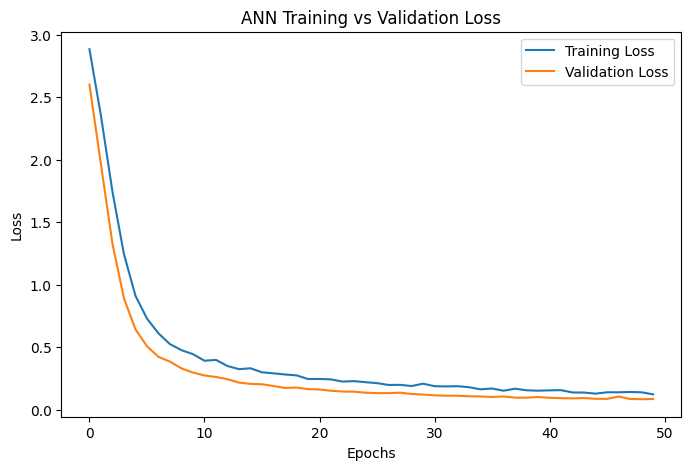

In [194]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('ANN Training vs Validation Loss')
plt.show()


In [195]:
test_loss, test_acc = ann_model.evaluate(
X_test_selected_scaled,
y_test_enc,
verbose=0
)
test_acc
ann_result = pd.DataFrame({
"Model": ["ANN"],
"Accuracy": [test_acc]
})

final_results = pd.concat([results_df, ann_result], ignore_index=True)
final_results.sort_values(by="Accuracy", ascending=False)


,Model,Accuracy
0,Random Forest,0.988636
1,Decision Tree,0.981818
5,ANN,0.979545
2,Logistic Regression,0.977273
3,KNN,0.963636
4,SVM,0.963636


Deep Learning Model
A simple Artificial Neural Network was implemented to evaluate the potential of deep learning on tabular agricultural data.
The model consisted of two hidden layers with dropout regularization to prevent overfitting.
Training and validation loss curves indicated stable convergence, with early stopping effectively limiting overfitting.
While the ANN achieved competitive performance, classical machine learning models such as Random Forest performed comparably or better, highlighting that deep learning is not always superior for structured data.

A structured comparison of multiple machine learning models was conducted using the same preprocessing pipeline and evaluation metric.
Random Forest achieved the highest accuracy (98.86%), demonstrating its ability to model complex non-linear relationships between soil nutrients and climatic conditions.
Decision Tree and Logistic Regression also performed strongly, highlighting the effectiveness of the engineered features.
The Artificial Neural Network achieved competitive performance but did not outperform tree-based models, indicating that deep learning does not necessarily provide advantages for structured tabular data with limited sample size.
These results emphasize the importance of model selection based on data characteristics rather than model complexity.